In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [3]:
x_train, x_val = train_test_split(train_data, test_size=0.2)

display(x_train.shape)
display(x_val.shape)

(961, 51)

(241, 51)

In [4]:
class PreprocessingLayer(torch.nn.Module):
    def forward(self, inputs: torch.Tensor):
        min_val = inputs.min(axis=0).values
        max_val = inputs.max(axis=0).values
        normalized_inputs = torch.where(
            (max_val - min_val) != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            torch.zeros_like(inputs)
        )
        return normalized_inputs

In [5]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        super().__init__()
        self.l2_lambda = torch.tensor(l2_lambda)
        self.prep_layer = PreprocessingLayer()
        self.encoder1 = torch.nn.Linear(input_shape[0], 18)
        self.encoder1_activation = torch.nn.ReLU()
        self.encoder2 = torch.nn.Linear(18, 8)
        self.encoder2_activation = torch.nn.Sigmoid()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 18),
            torch.nn.Sigmoid(),
            torch.nn.Linear(18, input_shape[0]),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        l2_activity_loss = self.l2_lambda * torch.sum(encoded ** 2)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        return decoded, l2_activity_loss
    
    def fit(self, inputs: np.ndarray, val_inputs: np.ndarray, batch_size: int, epochs: int, optimizer, criterion, patience: int, min_delta: float):
        inputs = torch.tensor(inputs.astype(np.float32))
        val_inputs = torch.tensor(val_inputs.astype(np.float32))
        targets = PreprocessingLayer()(inputs)
        val_targets = PreprocessingLayer()(val_inputs)
        batched_data = DataLoader(targets, batch_size=batch_size, shuffle=True)
        batch_steps = len(batched_data)
        training_loss = []
        validation_loss = []
        min_validation_loss = np.float32('inf')
        early_stop_counter = 0

        for epoch in range(epochs):
            self.train()
            epoch_decoder_losses = []
            epoch_val_losses = []
            epoch_total_losses = []
            epoch_total_val_losses = []
            for idx, batch in enumerate(batched_data):
                # Forward pass
                decoded, l2_loss = self(batch)
                loss = criterion(batch, decoded)
                loss_value = loss.item()
                epoch_decoder_losses.append(loss_value)

                # Compute total loss
                total_loss = loss + l2_loss
                total_loss_value = total_loss.item()  # This slows down the code if using GPU, since we convert this value from CUDA to a python float
                epoch_total_losses.append(total_loss_value)

                # Compute validation loss
                decoded, l2_loss = self(val_targets)
                val_loss = criterion(val_targets, decoded)
                val_loss_value = val_loss.item()
                epoch_val_losses.append(val_loss_value)

                # Compute total validation loss
                total_val_loss = val_loss + l2_loss
                total_val_loss_value = total_val_loss.item()
                epoch_total_val_losses.append(total_val_loss_value)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                # print(f"Epoch [{epoch + 1}/{epochs}], Step [{idx + 1}/{batch_steps}], decoder loss: {loss_value:.4f}, encoder1_activation l2 loss: {l2_loss:.4f}, total loss: {total_loss_value:.4f}")

            epoch_decoder_avg_loss = np.array(epoch_decoder_losses).mean()
            epoch_val_avg_loss = np.array(epoch_val_losses).mean()
            epoch_total_avg_loss = np.array(epoch_total_losses).mean()
            epoch_total_val_avg_loss = np.array(epoch_total_val_losses).mean()
            training_loss.append(epoch_total_avg_loss)
            validation_loss.append(epoch_total_val_avg_loss)

            # Early stopping - Stop training when a monitored metric has stopped improving.
            if epoch_total_val_avg_loss < (min_validation_loss + min_delta):
                min_validation_loss = epoch_total_val_avg_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                break

            print(f"Epoch [{epoch + 1}/{epochs}] (avg {batch_steps} steps): decoder loss: {epoch_decoder_avg_loss:.4f}, total loss: {epoch_total_avg_loss:.4f}, validation loss: {epoch_val_avg_loss:.4f}, total validation loss: {epoch_total_val_avg_loss:.4f}")
        
        return training_loss, validation_loss

In [6]:
class InferenceAutoencoder(Autoencoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse_loss = torch.nn.MSELoss(reduction='none')

    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        mse = self.mse_loss(prep, decoded)
        return torch.mean(mse, dim=1)  # Only return mse loss

In [7]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, eps=1e-07)

In [8]:
training_loss, validation_loss = ae.fit(x_train, x_val, 128, 500, optimizer, criterion, patience=5, min_delta=0)

Epoch [1/500] (avg 8 steps): decoder loss: 0.1888, total loss: 0.1905, validation loss: 0.1901, total validation loss: 0.1936
Epoch [2/500] (avg 8 steps): decoder loss: 0.1732, total loss: 0.1741, validation loss: 0.1749, total validation loss: 0.1767
Epoch [3/500] (avg 8 steps): decoder loss: 0.1587, total loss: 0.1592, validation loss: 0.1605, total validation loss: 0.1613
Epoch [4/500] (avg 8 steps): decoder loss: 0.1448, total loss: 0.1450, validation loss: 0.1468, total validation loss: 0.1472
Epoch [5/500] (avg 8 steps): decoder loss: 0.1316, total loss: 0.1318, validation loss: 0.1339, total validation loss: 0.1341
Epoch [6/500] (avg 8 steps): decoder loss: 0.1192, total loss: 0.1193, validation loss: 0.1217, total validation loss: 0.1218
Epoch [7/500] (avg 8 steps): decoder loss: 0.1078, total loss: 0.1078, validation loss: 0.1104, total validation loss: 0.1104
Epoch [8/500] (avg 8 steps): decoder loss: 0.0972, total loss: 0.0972, validation loss: 0.0999, total validation loss:

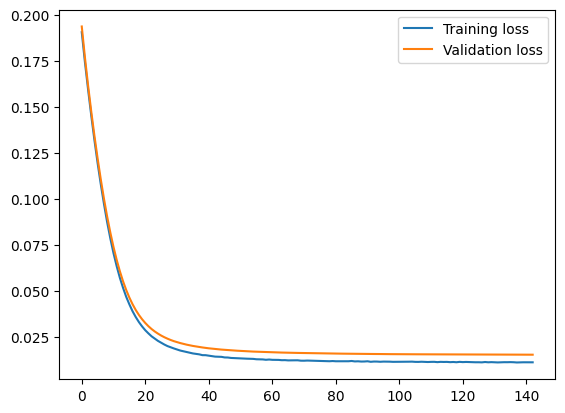

In [9]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.show()

In [10]:
iae = InferenceAutoencoder(input_shape=(51,), l2_lambda=1e-4)
iae.load_state_dict(ae.state_dict())

<All keys matched successfully>

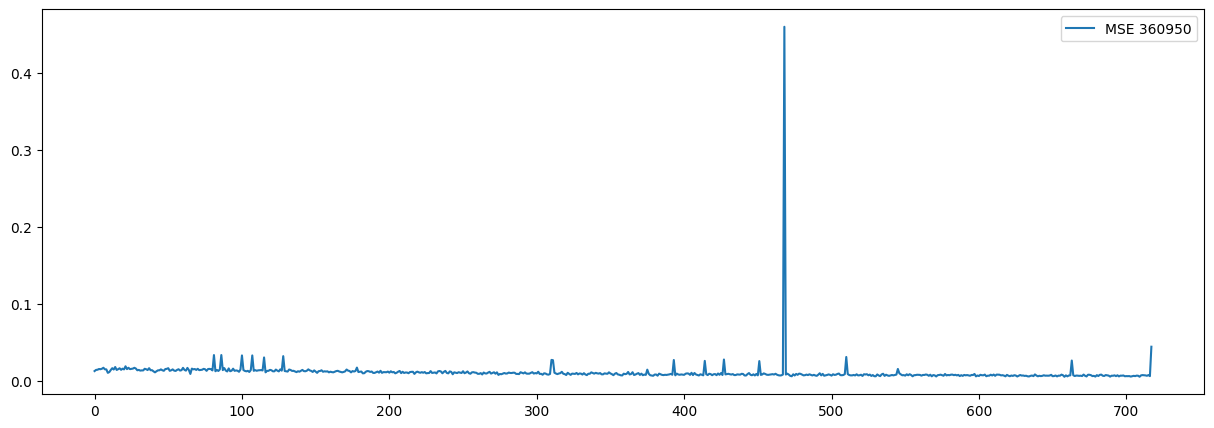

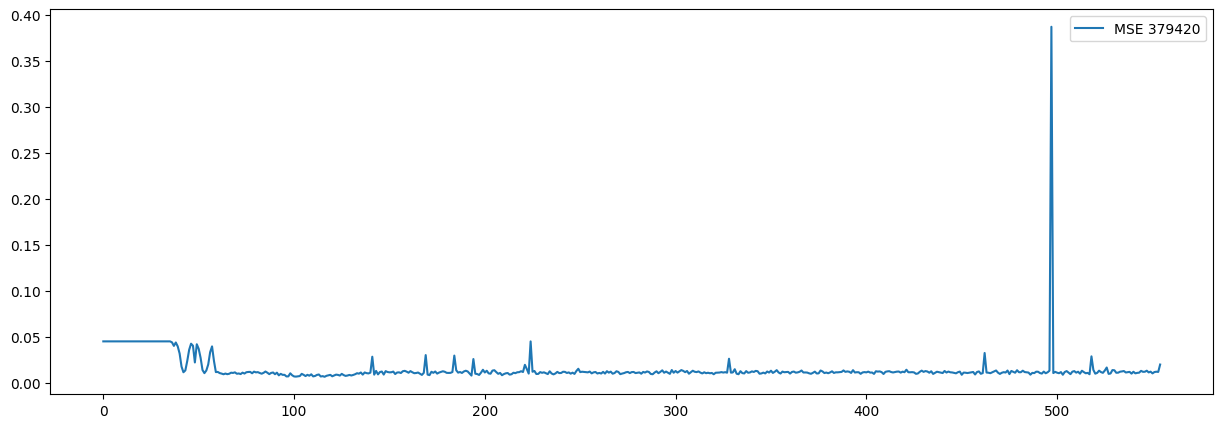

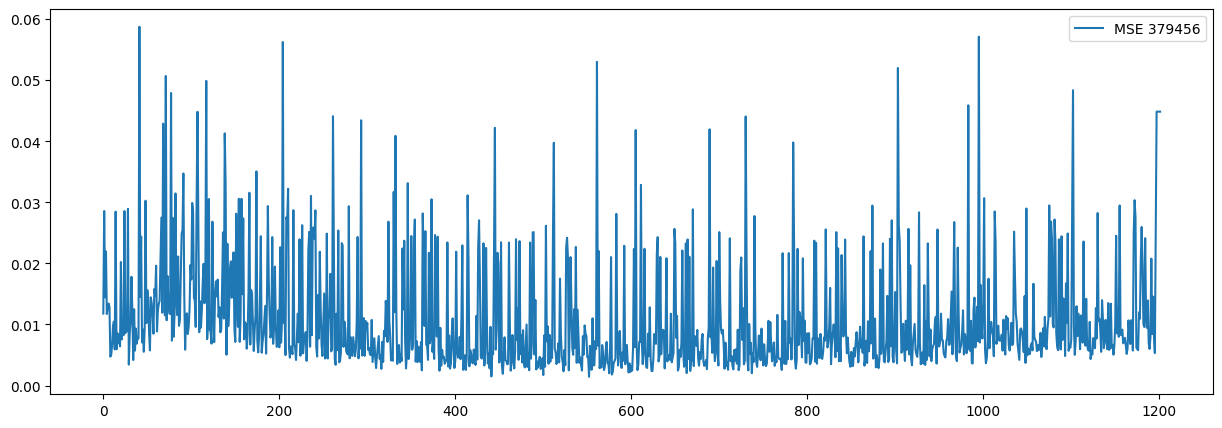

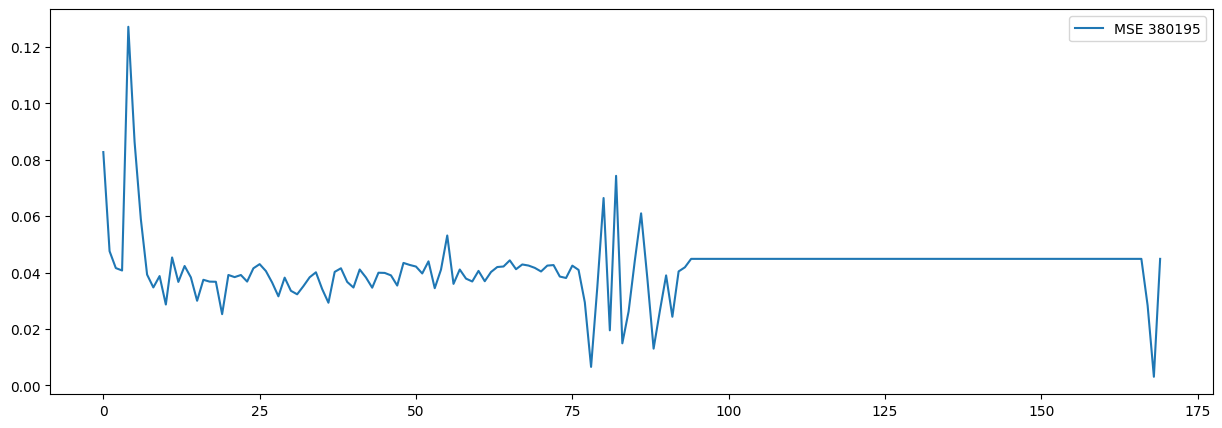

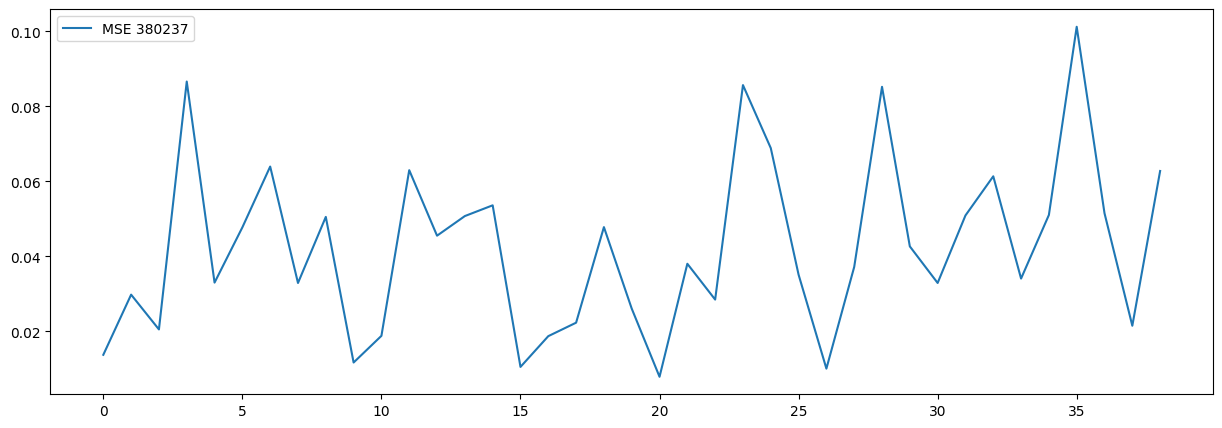

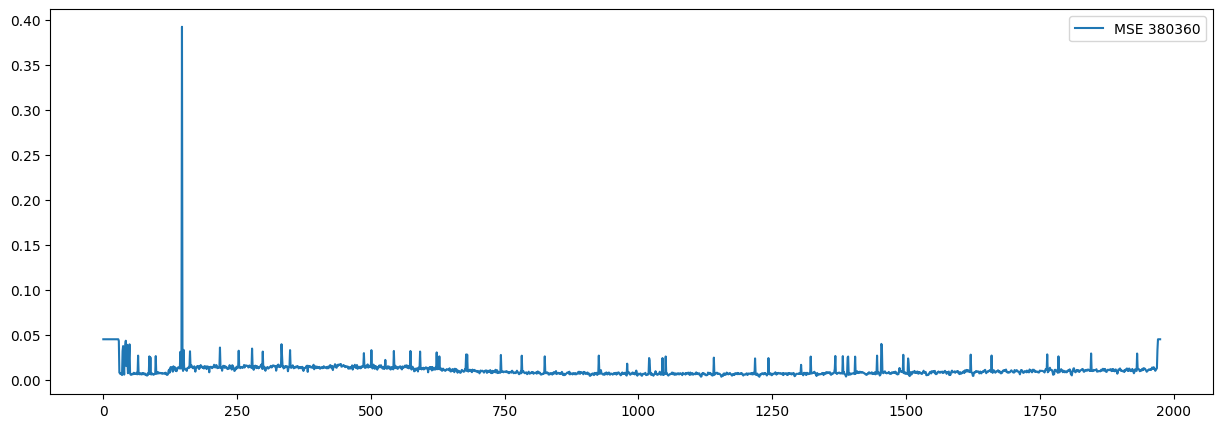

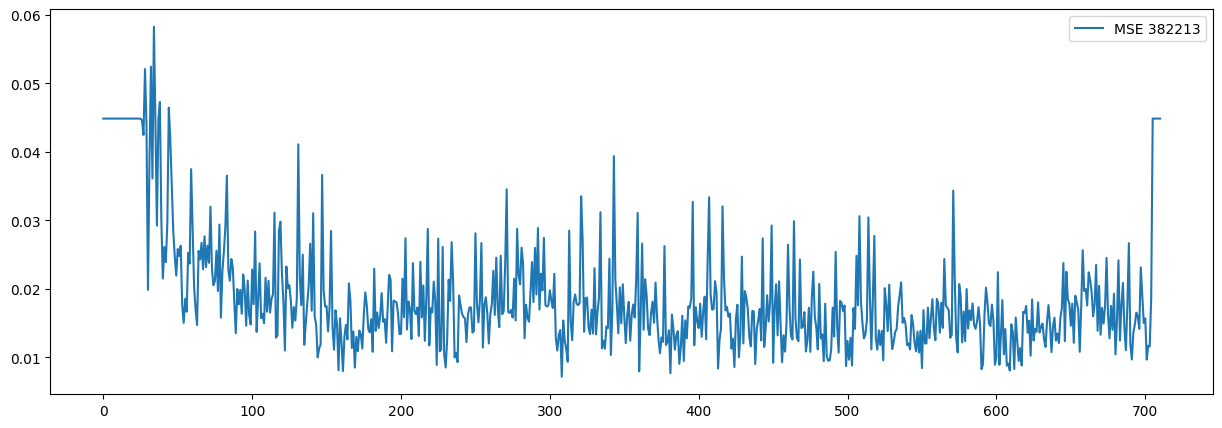

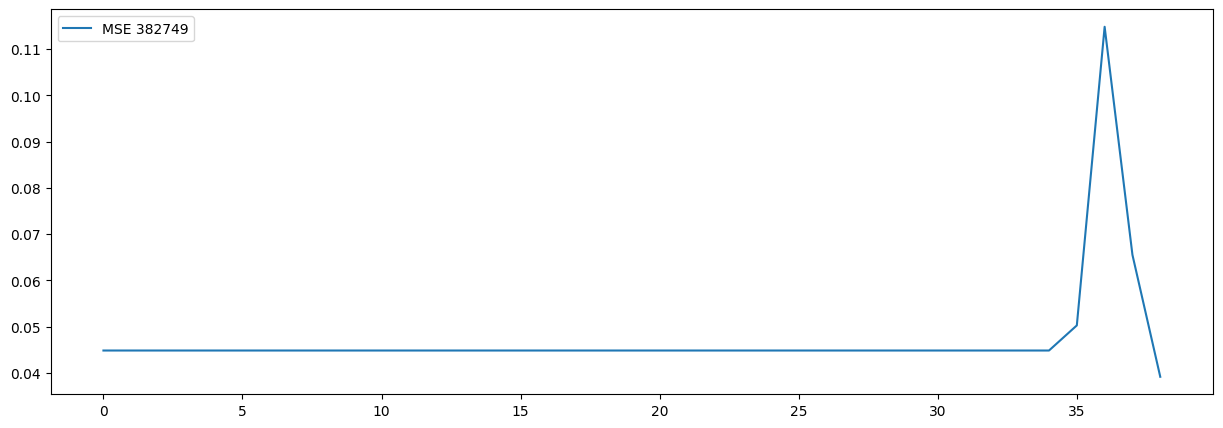

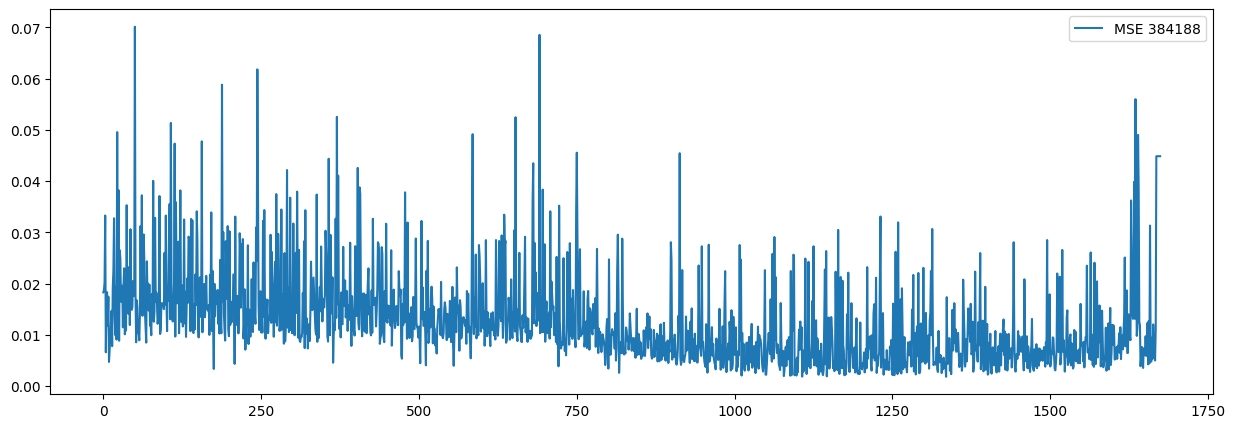

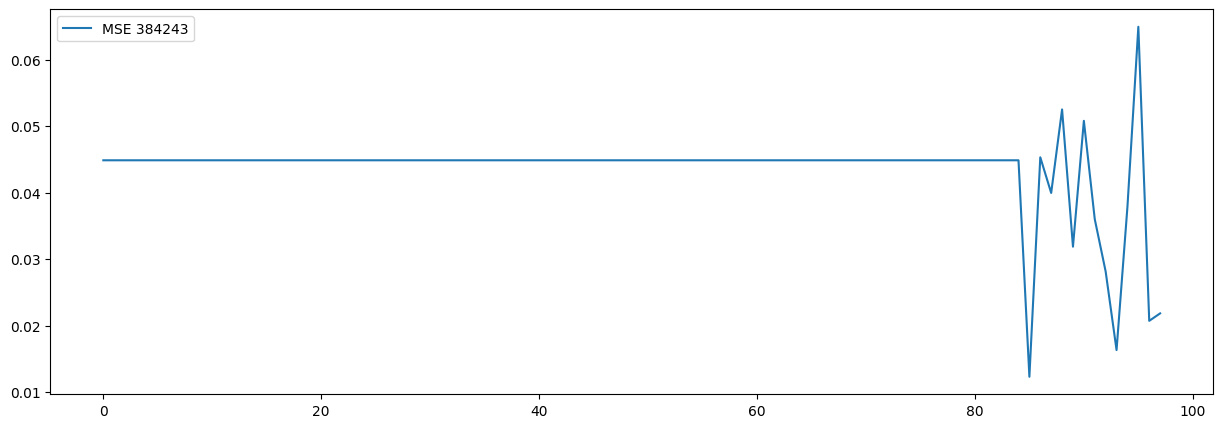

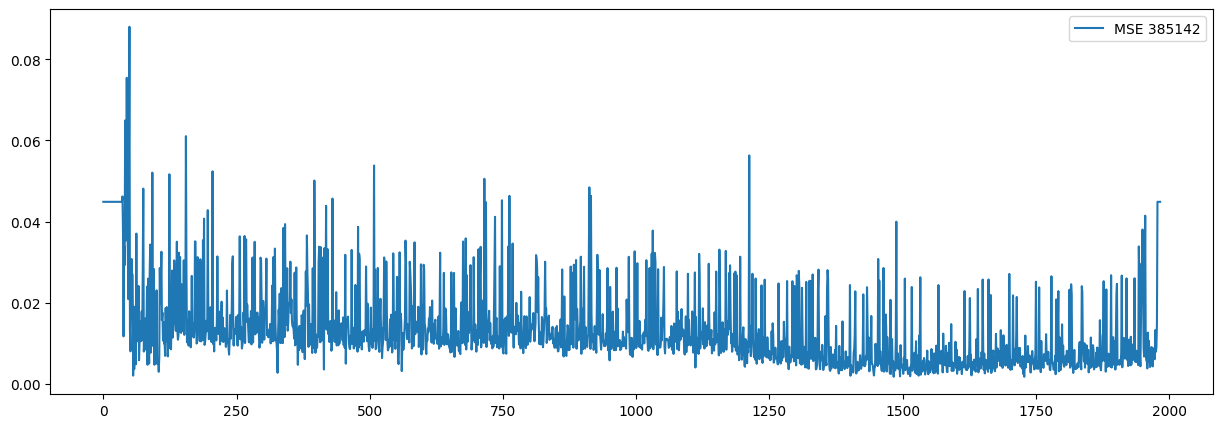

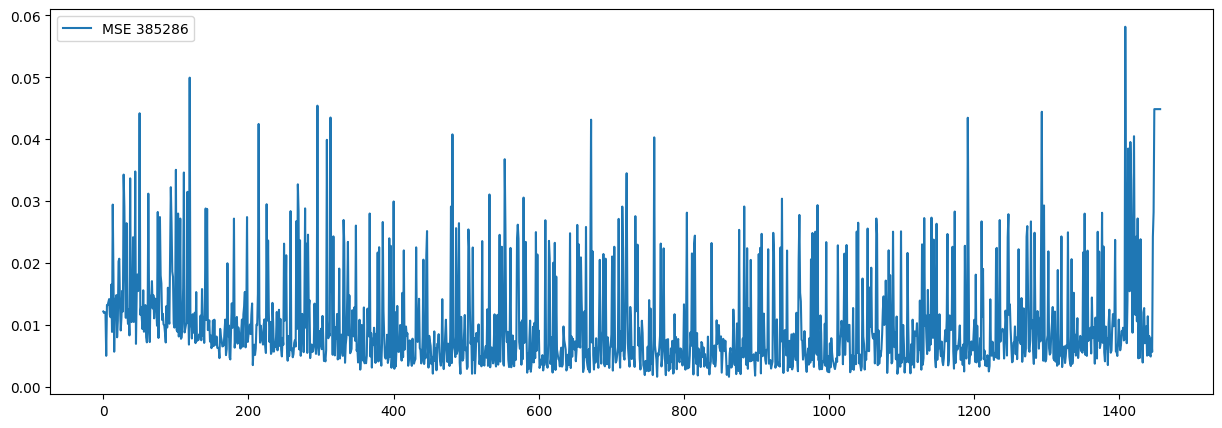

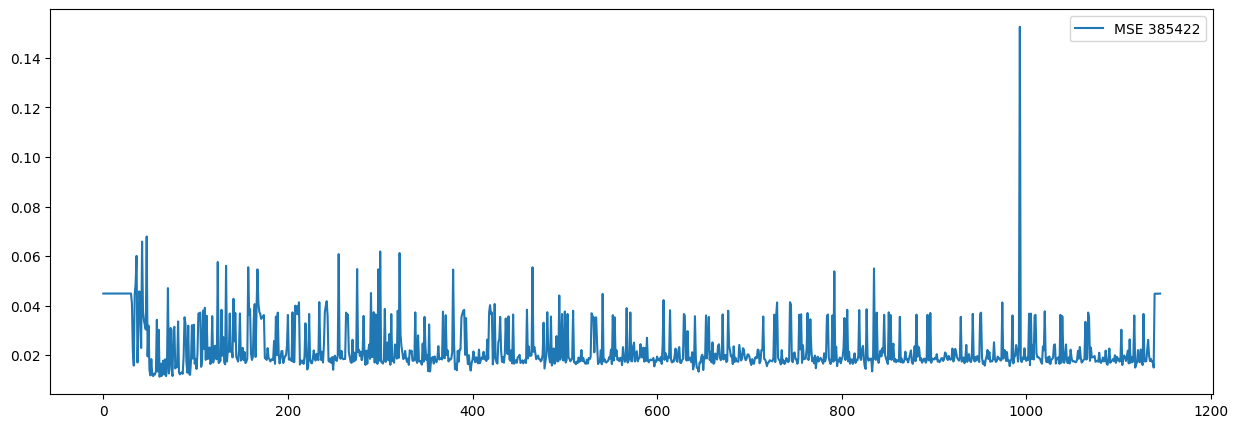

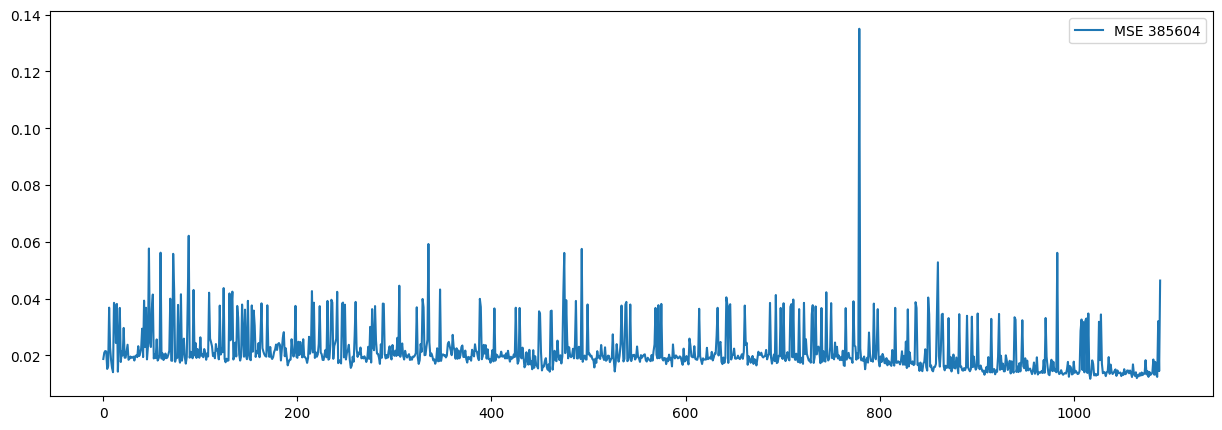

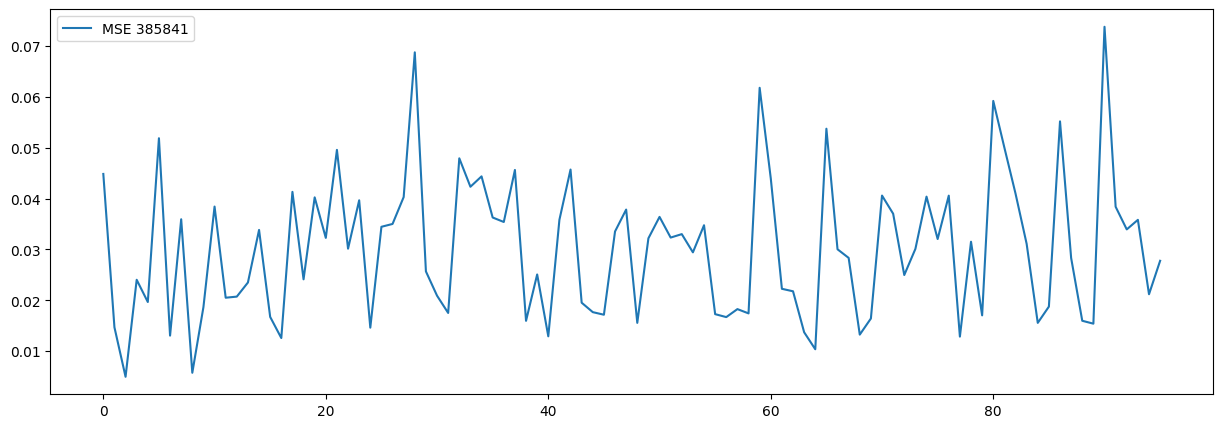

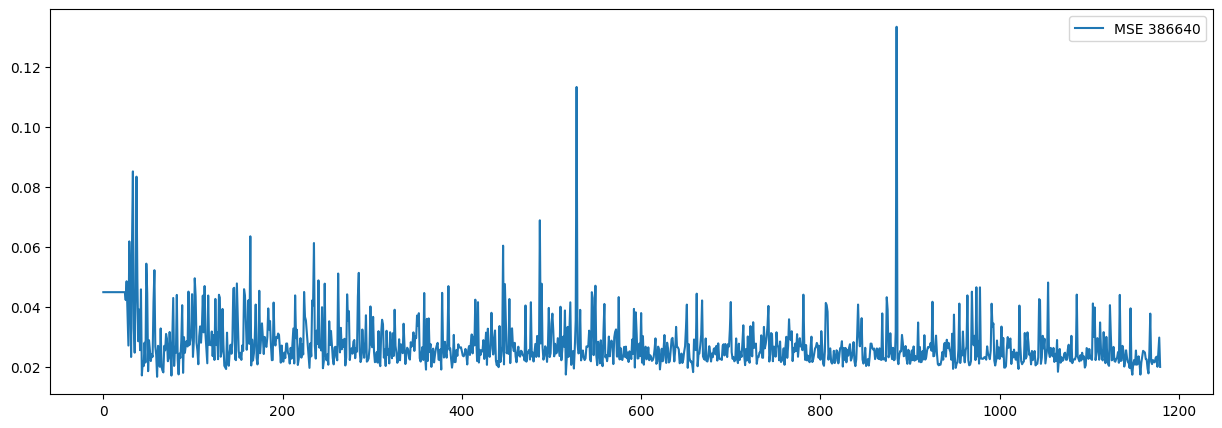

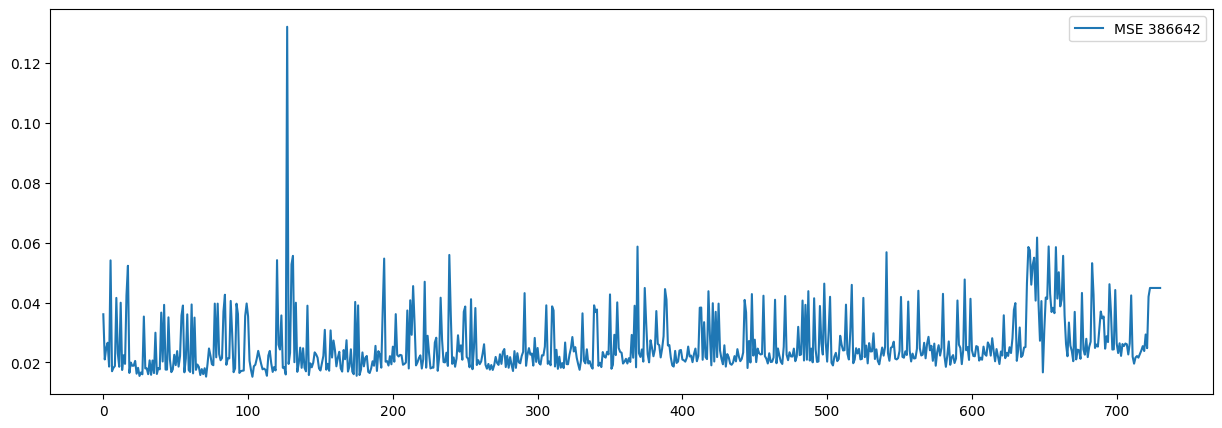

In [11]:
for run_number in np.unique(run_arr):
    run_data = data_arr[run_arr == run_number].astype(np.float32)
    run_data = torch.tensor(run_data)
    mse = iae(run_data).detach().numpy()

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [12]:
os.makedirs("../models/torch", exist_ok=True)

model_path = "../models/torch/state_dict.pth"
torch.save(iae.state_dict(), model_path)